In [1]:
# Imported Python files do not automatically reload after you modify them
# M1: Automatically Reload
%load_ext autoreload
%autoreload 2
# M2: Manual Reload
# import importlib
# import ksfdtw
# importlib.reload(ksfdtw)

# https://stackoverflow.com/questions/20309456/how-do-i-call-a-function-from-another-py-file
from ksfdtw import *

In [2]:
import numpy as np
import random
from tslearn.datasets import UCR_UEA_datasets
import matplotlib.pyplot as plt
import math


/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")

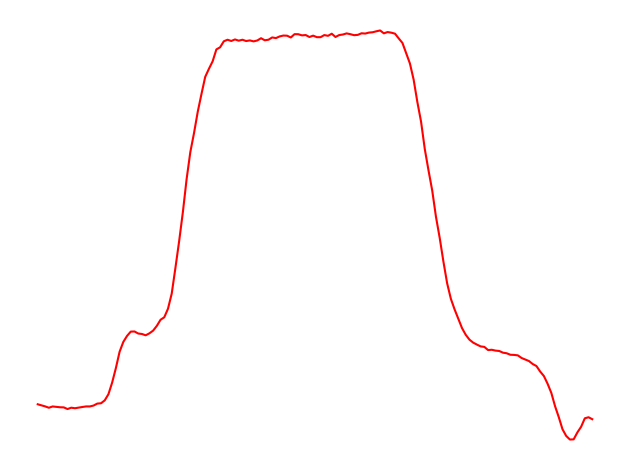

In [4]:
# gun
plt.plot(X_test[y_test == 1][0], color="red")
plt.axis('off')
plt.tight_layout()
plt.show()

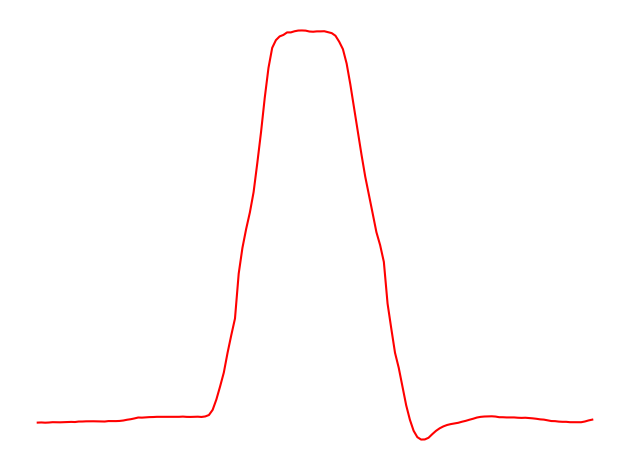

In [5]:
# pointing
plt.plot(X_test[y_test == 2][0], color="red")
plt.axis('off')
plt.tight_layout()
plt.show()

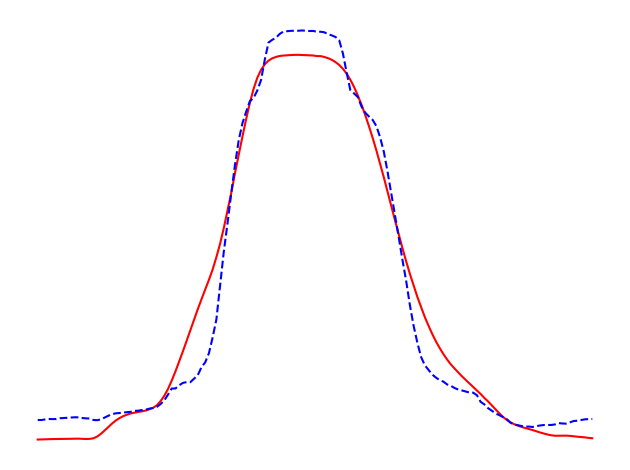

In [6]:
# gun
# Compute the mean time series
prototype_mean = np.mean(X_test[y_test == 1], axis=0)
# Compute the median time series
median_prototype = np.median(X_test[y_test == 1], axis=0)

# Plot the mean prototype
plt.plot(prototype_mean, label="Mean Prototype", color="red")
# Plot the median prototype
plt.plot(median_prototype, label="Median Prototype", color="blue", linestyle="--")
# plt.title("Idealized Prototype")
plt.xlabel("Time Step")
plt.ylabel("Value")
# plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

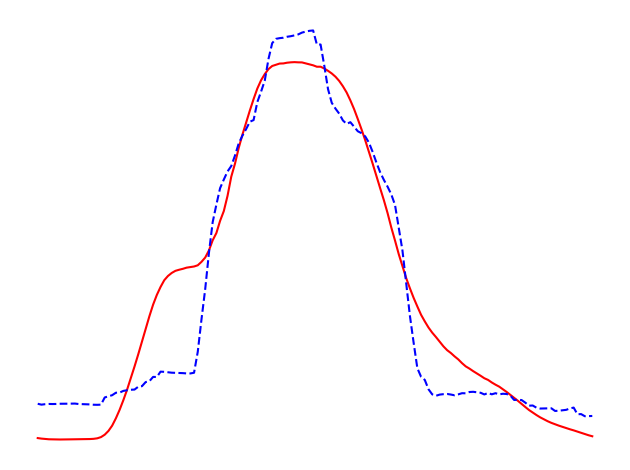

In [7]:
# pointing
# Compute the mean time series
prototype_mean = np.mean(X_test[y_test == 2], axis=0)
# Compute the median time series
median_prototype = np.median(X_test[y_test == 2], axis=0)

# Plot the mean prototype
plt.plot(prototype_mean, label="Mean Prototype", color="red")
# Plot the median prototype
plt.plot(median_prototype, label="Median Prototype", color="blue", linestyle="--")
# plt.title("Idealized Prototype")
plt.xlabel("Time Step")
plt.ylabel("Value")
# plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
def preprocess_ts(ts, P, l, final_length=50):
    
    ts = np.asarray(ts)
    if ts.ndim == 1:
        ts = ts[:, np.newaxis] # The format of a univariate time series is (len, 1)
    # Step 1: Compute allowed range for segment lengths
    original_len = ts.shape[0]
    avg_seg_len = original_len / P
    l_root = math.sqrt(l) # scaling factor
    min_len = max(1, int(avg_seg_len / l_root))
    max_len = int(avg_seg_len * l_root)

    # Step 2: generate random lengths in float within the range and normalize to len
    raw = [random.uniform(min_len, max_len) for _ in range(P)] 
    scale = original_len / sum(raw)
    scaled = [r * scale for r in raw]

    # Step 3: round to integers, then adjust to sum to len
    int_lengths = [int(round(s)) for s in scaled]
    diff = original_len - sum(int_lengths)

    # Step 4: fix rounding error
    while diff != 0:
        for i in range(P):
            if diff == 0:
                break
            if diff > 0 and int_lengths[i] < max_len:
                int_lengths[i] += 1
                diff -= 1
            elif diff < 0 and int_lengths[i] > min_len:
                int_lengths[i] -= 1
                diff += 1



    segments = []
    cutting_points = []
    interpolated_lengths = []
    start = 0
    for p in range(P):
        # seg_len = random.randint(min_len, max_len)
        # end = min(start + seg_len, original_len)
        end = start + int_lengths[p]
        seg = ts[start:end]
        cutting_points.append((start, end))

        # Rescale this segment to a random new length
        new_len = random.randint(min_len, max_len)
        seg_rescaled = nearest_neighbor_interpolation(seg, new_len)
        interpolated_lengths.append(seg_rescaled.shape[0])
        segments.append(seg_rescaled)

        start = end
        if start >= original_len:
            break

    # Concatenate all interpolated segments
    ts_concat = np.vstack(segments)

    # Compute cutting points on the concatenated sequence (before final rescale)
    cumulative_lengths = np.cumsum(interpolated_lengths)
    # print(cumulative_lengths)
    final_scale_cuts = np.round(cumulative_lengths / cumulative_lengths[-1] * final_length).astype(int).tolist()

    start = 0
    scaled_cutting_points = []
    for p in range(P):
        end = final_scale_cuts[p]
        scaled_cutting_points.append((start, end))
        start = end
    # print(scaled_cutting_points)

    # Final rescaling to target length
    ts_final = nearest_neighbor_interpolation(ts_concat, final_length)

    return ts_final.squeeze(), cutting_points, scaled_cutting_points

In [9]:
# preprocess_ts(X_train[0], 3, 2, 50)

In [10]:
# ----------------------------
# Parameters
# ----------------------------
P = 3
l = 2.0
final_len = 30

# ----------------------------
# Preprocess Dataset
# ----------------------------
random.seed(42)
# For X_train 
X_train_scaled, X_train_proc, train_cutting_orig, train_cutting_final = [], [], [], []
for ts in X_train:
    X_train_scaled.append(nearest_neighbor_interpolation(ts, final_len))
    proc, orig_cuts, final_cuts = preprocess_ts(ts, P, l, final_len)
    X_train_proc.append(proc)
    train_cutting_orig.append(orig_cuts)
    train_cutting_final.append(final_cuts)

# For X_test
X_test_scaled, X_test_proc, test_cutting_orig, test_cutting_final = [], [], [], []
for ts in X_test:
    X_test_scaled.append(nearest_neighbor_interpolation(ts, final_len))
    proc, orig_cuts, final_cuts = preprocess_ts(ts, P, l, final_len)
    X_test_proc.append(proc)
    test_cutting_orig.append(orig_cuts)
    test_cutting_final.append(final_cuts)

X_train_proc = np.array(X_train_proc)
X_train_scaled = np.array(X_train_scaled)
X_test_proc = np.array(X_test_proc)
X_test_scaled = np.array(X_test_scaled)

In [11]:
# ----------------------------
# Add Class-Dependent Gaussian Noise
# ----------------------------

# Step 1: Separate by label
X_train_proc = np.array(X_train_proc)
X_test_proc = np.array(X_test_proc)
y_train = np.array(y_train)
y_test = np.array(y_test)

positive_indices = np.where(y_train == y_train[0])[0]
negative_indices = np.where(y_train != y_train[0])[0]

# Step 2: Compute max per class
max_pos = np.max(X_train_proc[positive_indices])
max_neg = np.max(X_train_proc[negative_indices])

# Step 3: Compute variances
var_pos = 0.05 * max_pos
var_neg = 0.05 * max_neg

# Step 4: Add noise
def add_class_dependent_noise(X, y, var_pos, var_neg, pos_label):
    noisy_X = []
    for xi, yi in zip(X, y):
        if yi == pos_label:
            noise = np.random.normal(loc=0.0, scale=var_pos, size=xi.shape)
        else:
            noise = np.random.normal(loc=0.0, scale=var_neg, size=xi.shape)
        noisy_X.append(xi + noise)
    return np.array(noisy_X)

X_train_proc_noisy = add_class_dependent_noise(X_train_proc, y_train, var_pos, var_neg, y_train[0])
X_test_proc_noisy = add_class_dependent_noise(X_test_proc, y_test, var_pos, var_neg, y_train[0])


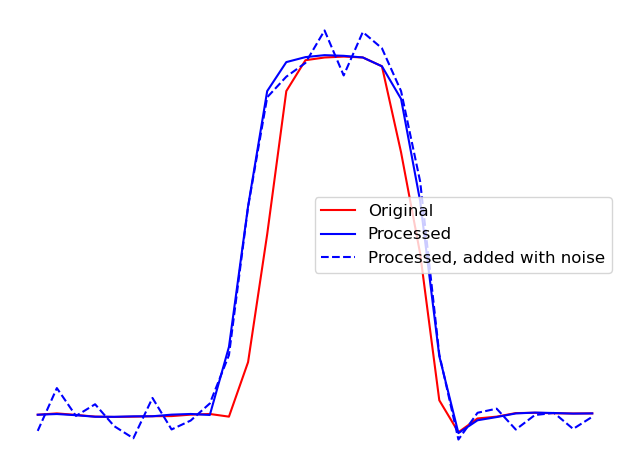

In [16]:
plt.plot(X_train_scaled[0], color="red", label="Original")
plt.plot(X_train_proc[0], color="blue", label="Processed")
plt.plot(X_train_proc_noisy[0], color="blue", linestyle='--', label="Processed, added with noise")
plt.legend(fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.savefig("../figures/GunPoint_processed.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
np.savez("../data/gunpoint_preprocessed.npz",
    # For X_train
    X_train=X_train,
    X_train_scaled=X_train_scaled,
    X_train_proc=X_train_proc,
    X_train_proc_noisy=X_train_proc_noisy,
    y_train=y_train,
    train_cutting_orig=train_cutting_orig,
    train_cutting_final=train_cutting_final,
    # For X_test
    X_test=X_test,
    X_test_scaled=X_test_scaled,
    X_test_proc=X_test_proc,
    X_test_proc_noisy=X_test_proc_noisy,
    y_test=y_test,
    test_cutting_orig=test_cutting_orig,
    test_cutting_final=test_cutting_final)